# Sinc Interpolation

## The Interpolation Formula

The sampling theorem tells us that a continuous function $x(t)$ that is bandlimited to half of the samplerate (which, for convenience, we will assume to be unity) can be recontructed exactly from its sample points $x[n]$ by sinc interpolation:
$$
\DeclareMathOperator{\sinc}{sinc}
x(t) = \sum_{n=-\infty}^\infty x[n] \sinc(t-n)
$$
\begin{equation}
  \label{SincFormula}
  x(t) = \sum_{n=-\infty}^\infty x[n] \sinc(t-n)
\end{equation}
where the $\sinc$ function is defined as:
$$
\sinc(t) = \frac{\sin(\pi t)}{\pi t}
$$
For implementing the sinc function, we need to take care of the special case where $t=0$ in order to avoid a division by zero error. The desired value at $t=0$ can be found by considering the limit as t approaches zero, which in turn can be found by the l'Hospital rule as:
$$
\lim_{t \rightarrow 0} \frac{\sin(\pi t)}{\pi t} = \lim_{t \rightarrow 0} \frac{\pi \cos(\pi t)}{\pi} = 1
$$
So, we may implement the $\sinc$ function in python as follows:

In [1]:
from math import pi
def sinc(x):
    if(x == 0):
        return 1
    else:
        return sin(pi*x)/(pi*x)

The sinc function is also availabe in numpy which we will actually use in practice. Let's now have a look at a plot of the function:

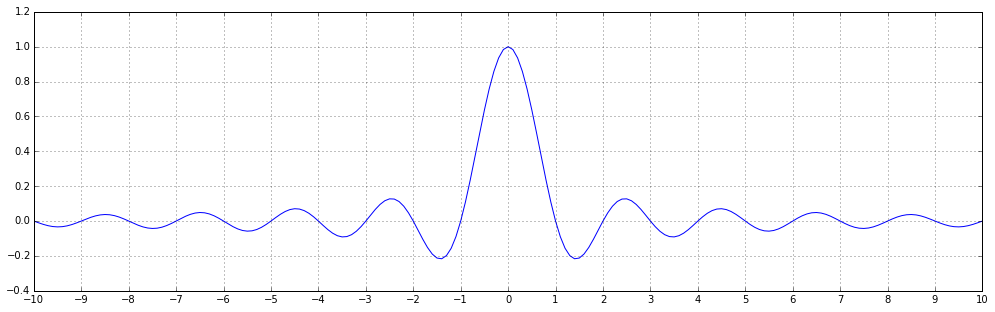

In [2]:
from numpy import linspace, sinc
from matplotlib.pyplot import *
%matplotlib inline
t = linspace(-10, 10, 201)
s = sinc(t)
plot(t, s)
xticks(range(-10, 11, 1))
grid()
fig = gcf()
fig.set_size_inches(17, 5)

##An Example

To see how the sinc interpolation formula works in practice, we create a random sequence of 10 points to serve as example signal as example for our interpolation.

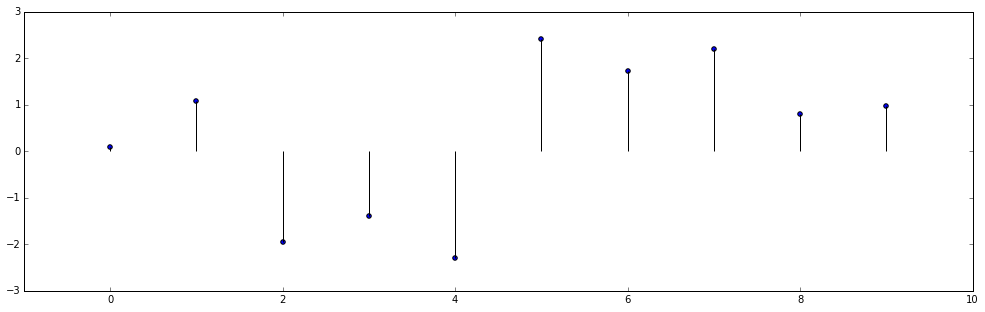

In [3]:
from numpy.random import seed, normal
seed(8)
N = 10                            # number of datapoints/samples
t = linspace(0, 9, N)             # sampled time axis
x = normal(0, 1, N)               # random datapoints
scatter(t, x), vlines(t, 0, x)    # make a stem plot
xlim(-1, 10), ylim(-3, 3)
fig = gcf()
fig.set_size_inches(17, 5)

The whole point of interpolation is, in general, to somehow find function values in between the datapoints. Linear interpolation would simply connect the datapoints with straight lines, like this:

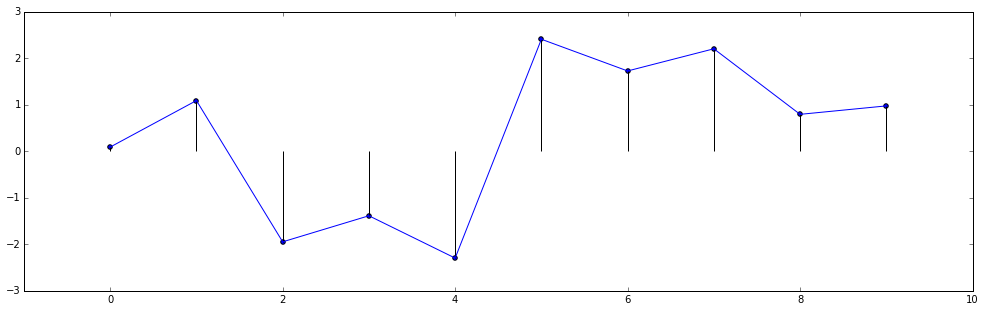

In [4]:
plot(t, x), scatter(t, x), vlines(t, 0, x)
xlim(-1, 10), ylim(-3, 3)
gcf().set_size_inches(17, 5)

Linear interpolation is very crude and not suitable for high quality audio resampling. Instead, the ideal continuous interpolating function through our known datapoints would be given by sinc interpolation. Conceptually, we would center a sinc kernel on every datapoint, scale it by the value of the sample there and add up all these scaled sinc functions to produce the continuous interpolating function. To visualize it, we create a pseudo-continuous time-axis by sampling the time-variable much more densely than in the sequence above (in  which our sampling interval was unity). We plot the scaled and shifted sinc kernels in gray, where the one centered at sample index 5 is highlighted by using a darker shade. The sum of all the scaled and shifted sinc kernels gives our interpolating function which is plotted in black.

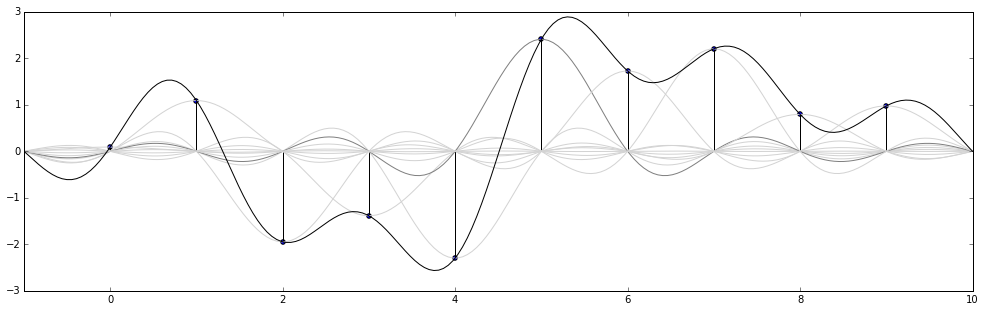

In [28]:
from numpy import zeros
Ni = 200                    # number of interpolated datapoints
ti = linspace(-1, 10, Ni)   # dense time-axis for interpolation
sn = zeros(Ni)              # (scaled) sinc kernel centered at n-th sample
xi = zeros(Ni)              # interpolated values at ti
for n in range(0, N):
    for k in range(0, Ni):
        sn[k] = x[n] * sinc(ti[k]-n)
    c = "gray" if n == 5 else "lightgray"
    plot(ti, sn, color=c)
    xi += sn
plot(ti, xi, color="black")
scatter(t, x), vlines(t, 0, x)
xlim(-1, 10), ylim(-3, 3)
gcf().set_size_inches(17, 5)

Observe how the interpolant passes exactly through our datapoints. This is because the value of the sinc function at zero is unity - so if we shift a sinc to our datapoint and scale it by the sample-value, it will pass through the point. Also, because the sinc function has zero crossings at all nonzero integer values, all the other sinc kernels go through one of their zero-crossings at the respective point, so they contribute zero to the sum at that point. In between our datapoints, the sum of sincs tends to show considerable oscillations. What we are seeing here can be interpreted as an manifestation of the Gibbs phenomenon. This is because the sinc function is the impulse response of an ideal brickwall lowpass filter, tuned to half of the sample rate (half of the samplerate is also called the Nyquist frequency). In the plot, our interpolating function was be used for producing values not only in between our original datapoints but also beyond the endpoints - in which case it would properly be called not inter- but extrapolation.

## Windowing

Formally, the interpolation formula involves an infinite sum over scaled sample values. In practice, our sampled sequences have finite length and we implicitly assume that sample values outside the range are equal to zero. Leaving out zero values from a sum doesn't change the value of the sum, so the infinite sum can be truncated to a finite one over the available sample values - which was done in the plotting code above. However, to compute an interpolated value at an arbitrary time instant $t$ between sampling instants $n$ and $n+1$, all values of the whole sequence were used. For our 10 point toy example, this is not much of a problem but in practical audio applications, the sequences are often hundreds of thousands of samples long which makes it prohibitively computationally expensive to use all of the sample values for interpolation. Instead, we confine the range of used sample values to some neighbourhood of $t$. Linear interpolation would just use the two samples at $n$ and $n+1$, by the way. Noting that the sinc function decays toward plus/minus infinity, it seems a reasonable idea that values from far away from the center contribute only very little to the sum, so leaving them out by truncating the sum further might introduce a tolerable error. 

to use just a limited portion of the function where the values are